In [1]:
%pylab inline
import keras
import keras.backend as K
from keras import Input, Model, Sequential
from keras.layers import Lambda, LSTM, RepeatVector, Dense, TimeDistributed, Bidirectional, concatenate,\
Conv1D, MaxPooling1D, UpSampling1D, BatchNormalization, Activation, Flatten, Reshape
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from matplotlib import pyplot as plt
import os, shutil

Populating the interactive namespace from numpy and matplotlib


/home/luca/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [ ]:
def split_data(dataset, timesteps):
    D = dataset.shape[1]
    if D < timesteps:
        return None
    elif D == timesteps:
        return dataset
    else:
        splitted_data, remaining_data = np.hsplit(dataset, [timesteps])
        remaining_data = split_data(remaining_data, timesteps)
        if remaining_data is not None:
            return np.vstack([splitted_data, remaining_data])
        return splitted_data

In [50]:
normalized_transactions_filepath = "../../datasets/berka_dataset/usable/normalized_transactions.npy"
normalized_transactions_balances_filepath = "../../datasets/berka_dataset/usable/normalized_transactions_balances.npy"

timesteps = 200
transactions = np.load(normalized_transactions_filepath)
np.random.shuffle(transactions)
transactions = transactions[:4500, -timesteps:]
N, D = transactions.shape
print(N, D)

4500 200


In [51]:
class PredictiveModel:
    def __init__(self, timesteps):
        self._timesteps = timesteps
        
    def build_model(self, lr):
        optimizer = Adam(lr=lr, clipnorm=1.0)
        model_inputs = Input((self._timesteps,))
        
        prediction = Lambda(lambda x : K.expand_dims(x))(model_inputs)
        prediction = LSTM(32, return_sequences=True)(prediction)
        prediction = TimeDistributed(Dense(1, activation='tanh'))(prediction)
        prediction = Lambda(lambda x : K.squeeze(x, -1))(prediction)
        
        self._model = Model(model_inputs, prediction)
        self._model.compile(loss='mse', optimizer=optimizer)
        return self._model
    
    def train(self, epochs, x_train, y_train, x_val, y_val):
        def schedule(epoch):
            return max(0.01 *.75**epoch, 0.00001)
        
        scheduler = keras.callbacks.LearningRateScheduler(schedule, verbose=1)

        self._model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs, callbacks=[scheduler])
        
    @staticmethod
    def _huber_loss(y_true, y_pred, clip_delta=1.0):
        error = y_true - y_pred
        cond  = K.abs(error) < clip_delta

        squared_loss = 0.5 * tf.keras.backend.square(error)
        linear_loss  = clip_delta * (K.abs(error) - 0.5 * clip_delta)

        return tf.where(cond, squared_loss, linear_loss)
    
    def _huber_loss_mean(self, y_true, y_pred, clip_delta=1.0):
        return K.mean(self._huber_loss(y_true, y_pred, clip_delta))

In [52]:
x_train = transactions[:,:-1]
y_train = transactions[:, 1:]

N = x_train.shape[0]
split = int(N*0.3)
shuffling_indices = np.random.shuffle(np.arange(N))

x_train = np.squeeze(x_train[shuffling_indices], 0)

x_val = x_train[:split]
x_train = x_train[split:]

y_train = np.squeeze(y_train[shuffling_indices], 0)

y_val = y_train[:split]
y_train = y_train[split:]

lr = 0.01
epochs = 30

In [53]:
predictive_model = PredictiveModel(timesteps-1)
model = predictive_model.build_model(lr)
predictive_model.train(epochs, x_train, y_train, x_val, y_val)

Train on 3150 samples, validate on 1350 samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
Epoch 1/30
3150/3150 [==============================] - 47s 15ms/step - loss: 0.0516 - val_loss: 0.0503

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0075.
Epoch 2/30
3150/3150 [==============================] - 47s 15ms/step - loss: 0.0497 - val_loss: 0.0503

Epoch 00003: LearningRateScheduler reducing learning rate to 0.005625.
Epoch 3/30
3150/3150 [==============================] - 49s 15ms/step - loss: 0.0496 - val_loss: 0.0503

Epoch 00004: LearningRateScheduler reducing learning rate to 0.00421875.
Epoch 4/30
3150/3150 [==============================] - 46s 15ms/step - loss: 0.0495 - val_loss: 0.0497

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0031640625.
Epoch 5/30
1504/3150 [=============>................] - ETA: 25s - loss: 0.0493

KeyboardInterrupt: 

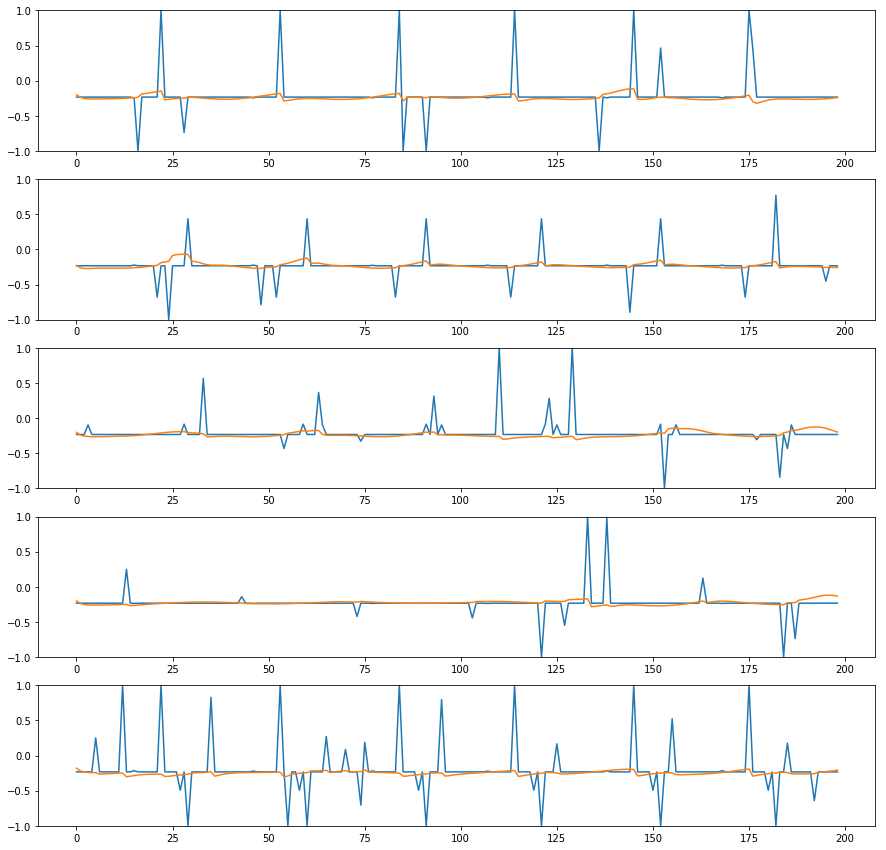

In [54]:
samples = 5
indexes = np.random.choice(split, samples)

plt.subplots(samples, 1, figsize=(15, 3*samples))
for i, index in enumerate(indexes):
    plt.subplot(samples, 1, i+1)
    plt.plot(y_val[index])
    plt.plot(model.predict(x_val[index:index+1]).T)
    plt.ylim(-1, 1)
plt.show()